In [1]:
from pprint import pprint as pprint
import numpy as np
import matplotlib.pyplot as plt

import control as pc

%pylab inline

import pandas as pd

from sysident import loadtools

import scipy as sp
import numpy.linalg as la

import sympy

Populating the interactive namespace from numpy and matplotlib


In [2]:
folder = "/home/lth/jupyter_nb/optimization/models/"
#fname = folder+"ss1_20180724-082630_poles2_ident_pade1_0:036_control_20180724-092309.npy"
#fname = folder+"ss2_20180724-082631_poles3_ident_pade2_0:036_control_20180724-092409.npy"
#fname = folder+"ss3_position_20180717-104106_poles3_ident_pade1_0:032_control_20180724-092445.npy"
fname = folder+"ss5_20180724-082628_poles3_ident_pade1_0:032_control_20180724-092522.npy"
#fname = folder+"ss6_20180724-082629_poles4_ident_pade2_0:032_control_20180724-092618.npy"

res, _ = loadtools.loadNPY(fname)
pprint(res.keys())

['A',
 'Ck',
 'C',
 'B',
 'ro',
 'D',
 'plot_input_step',
 'ni',
 'plot_control_step_s',
 'Ak',
 'plot_control_step_y',
 'u_max',
 'plot_control_step_u',
 'Ek',
 'plot_model_step',
 'plot_control_step_delay_u',
 'delay',
 'plot_control_step_delay_y',
 'X0',
 'Bk',
 'Dk']


Text(0.5,1,u'identification/Manual_real_model_huber.ipynb')

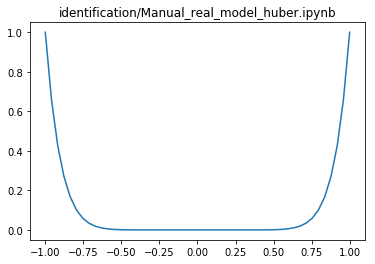

In [3]:
lins = np.linspace(-1, 1)
plt.plot(lins, np.power(lins, 10))
plt.title("identification/Manual_real_model_huber.ipynb")


101


(-1, 4)

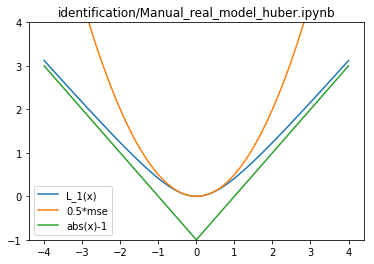

In [4]:
# plt.plot(sp.special.pseudo_huber(0.2, np.linspace(-1, 1)), label="delta=0.2")
from sklearn.metrics import mean_squared_error
#mse = mean_squared_error(A, B)

lins = np.linspace(-4, 4, num=101)
print len(lins)
zer = lins*0
mse = [0.5*mean_squared_error([x], [0]) for x in lins]

plt.plot(lins, sp.special.pseudo_huber(1, lins), label="L_1(x)")
plt.plot(lins, mse, label="0.5*mse")
plt.plot(lins, np.abs(lins)-1, label="abs(x)-1")
plt.legend()
plt.title("identification/Manual_real_model_huber.ipynb")

plt.ylim(-1,4)

In [5]:
# Creates a PT2+delay system from parameters
def get_systems(K, T, D, Td, Td_o=1):
    sys0 = pc.tf([K],[T**2, 2*D*T, 1])
    sys = pc.series(pc.tf(*pc.pade(Td, Td_o)), sys0)
    return sys0, sys

In [6]:
from scipy.optimize import minimize

pole_limit = -70 

# Optimization function:
# creates PT2-d system, transforms to modal form,
# recreates A with idealized A (eye*eigval)
# ma
def fun(arg, Td_o=1, show=False):
    
    K, D, T, Td = arg
    #print K, D, T, Td
    #T = np.abs(T)
    
    sys0, sys = get_systems(K, T, D, Td, Td_o)
    
    ss = pc.tf2ss(sys)
    
    eigval, Tzx = la.eig(ss.A)
    A_modal = la.solve(Tzx, ss.A).dot(Tzx)
    B_modal = la.solve(Tzx, ss.B)
    C_modal = ss.C.dot(Tzx)
    D_modal = ss.D
    
    t, y = pc.step_response(pc.ss(np.eye(len(eigval))*eigval, B_modal, C_modal, D_modal))
    
    df1 = pd.DataFrame(res['plot_input_step'][1], index=res['plot_input_step'][0])
    df2 = pd.DataFrame(y, index=t).fillna(np.inf)
    #print df2
    df3 = pd.concat([df1, df2], axis=1).interpolate()
    
    df_diff = df3.diff(axis=1).iloc[:,1]
    #print np.array(df_diff.cumsum().tail(), dtype=float64)
    
    poles = pc.pole(pc.ss(np.eye(len(eigval))*eigval, B_modal, C_modal, D_modal))
    #print poles[poles < -pole_limit]
    #print poles.min()
    p = np.sum(np.power(poles[poles < pole_limit], 10))
    #print poles
    #print p
    r = sp.special.pseudo_huber(0.2, np.array(df_diff, dtype=float64)).cumsum()[-1]
    
    #r = np.array(df3.diff(axis=1).abs().cumsum())[-1][1]
    
    if np.isnan(r):
        r = np.inf
    
    if show:
        plt.plot(t, y)
        plt.plot(*res['plot_input_step'])
        plt.show()

        df_diff.plot()
        print r+p, '>>', arg
    return r+p

#fun([1, 1, 0.1, 0.1], show=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


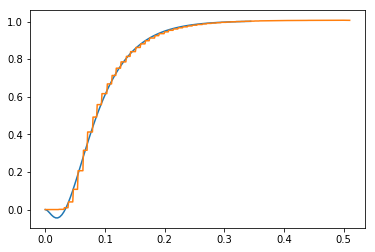

0.06936052628070463 >> [1.0041837  1.1233985  0.0300641  0.03306113]
[-60.49399987 -54.39316288 -20.34039022]
sys0: A = [[  0.         -11.06378158]
 [100.         -74.7335531 ]]

B = [[-11.11006912]
 [  0.        ]]

C = [[ 0. -1.]]

D = [[0.]]

---
sys: A = [[ 7.10542736e-15 -7.66708106e-15  6.69292402e+00]
 [ 1.00000000e+02  2.00673740e-14  5.62730971e+01]
 [ 0.00000000e+00 -1.00000000e+02 -1.35227553e+02]]

B = [[  6.7209252 ]
 [-11.11006912]
 [  0.        ]]

C = [[ 0.  0. -1.]]

D = [[0.]]



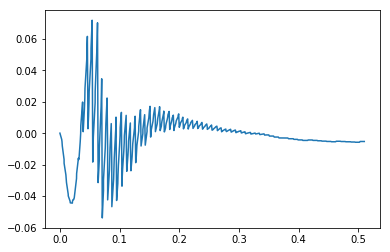

In [16]:
result = minimize(fun, [1, 1, 0.1, 0.1], method='Powell')
fun(result.x, show=True)

K, D, T, Td = result.x
#Td_o = 1 !!!!!!!!!!!!!!!!
sys0, sys1 = get_systems(K, T, D, Td, Td_o=1)
ss = pc.tf2ss(sys1)
eigval, Tzx = la.eig(ss.A)
A_modal = la.solve(Tzx, ss.A).dot(Tzx)
B_modal = la.solve(Tzx, ss.B)
C_modal = ss.C.dot(Tzx)
D_modal = ss.D

print pc.pole(sys)

print "sys0:", pc.tf2ss(sys0)
print "---"
print "sys:", pc.tf2ss(sys)

In [17]:
fname = 'ss_{}_poles{}_manual_ident_huber_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(pc.pole(sys1)), 'pade{}_{}'.format(1, Td))

ss1 = pc.tf2ss(sys1)
loadtools.saveDelayModel(fname, ss1.A, ss1.B, ss1.C, ss1.D, Td)

Creating new file: ss_20190206-114254_poles3_manual_ident_huber_pade1_0.0330611300999.npy


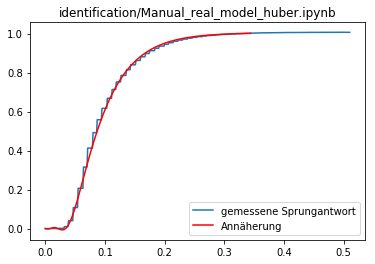

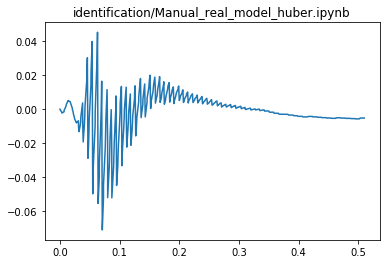

In [18]:
# System pade 3rd order
sys0, sys3 = get_systems(K, T, D, Td, Td_o=3)

t, y = pc.step_response(sys3)
plt.plot(*res['plot_input_step'], label="gemessene Sprungantwort")
plt.plot(t, y, 'r', label=u"Annäherung")
plt.legend()
plt.title('identification/Manual_real_model_huber.ipynb')
plt.show()

df1 = pd.DataFrame(res['plot_input_step'][1], index=res['plot_input_step'][0])
df2 = pd.DataFrame(y, index=t).fillna(np.inf)
#print df2
df3 = pd.concat([df1, df2], axis=1).interpolate()

df_diff = df3.diff(axis=1).iloc[:,1]

df_diff.plot(label="narf")
plt.title('identification/Manual_real_model_huber.ipynb')
plt.show()


In [19]:
print sys3

fname = 'ss_{}_poles{}_manual_ident_huber_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(pc.pole(sys3)), 'pade{}_{}'.format(3, Td))

ss3 = pc.tf2ss(sys3)
loadtools.saveDelayModel(fname, ss3.A, ss3.B, ss3.C, ss3.D, Td)

print sys0
ss0 = pc.tf2ss(sys0)

fname = 'ss_{}_poles{}_manual_ident_huber_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(pc.pole(sys0)), 'no_delay_{}'.format(Td))
loadtools.saveDelayModel(fname, ss0.A, ss0.B, ss0.C, ss0.D, Td)



              -1.004 s^3 + 364.5 s^2 - 5.512e+04 s + 3.335e+06
---------------------------------------------------------------------------
0.0009039 s^5 + 0.3956 s^4 + 75.13 s^3 + 7072 s^2 + 2.792e+05 s + 3.321e+06

Creating new file: ss_20190206-114257_poles5_manual_ident_huber_pade3_0.0330611300999.npy

            1.004
-----------------------------
0.0009039 s^2 + 0.06755 s + 1

Creating new file: ss_20190206-114257_poles2_manual_ident_huber_no_delay_0.0330611300999.npy


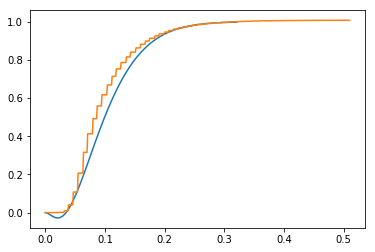

16.406335481286547


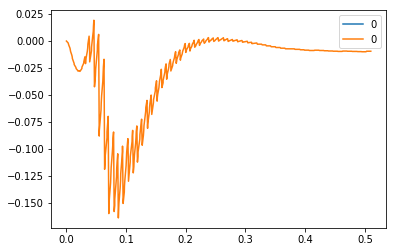

In [8]:
df1 = pd.DataFrame(res['plot_input_step'][1], index=res['plot_input_step'][0])
df2 = pd.DataFrame(res['plot_model_step'][1], index=res['plot_model_step'][0])

df3 = pd.concat([df1, df2], axis=1).interpolate()

plt.plot(*res['plot_model_step'])
plt.plot(*res['plot_input_step'])
plt.show()

df3.diff(axis=1).plot()
r = np.array(df3.diff(axis=1).abs().cumsum())[-1][1]
print r

In [9]:
K, D, T, Td = result.x

#Td_o = 1 !!!!!!!!!!!!!!!!
sys0, sys = get_systems(K, T, D, Td)
ss = pc.tf2ss(sys)


In [10]:
eigval, Tzx = la.eig(ss.A)
print eigval
print Tzx

[-19.07968575 -57.58838136 -73.63698135]
[[-0.2489397  -0.10248497 -0.08686873]
 [-0.7703376  -0.67631778 -0.6061385 ]
 [ 0.58703408  0.72944574  0.790601  ]]


In [11]:
A_modal = la.solve(Tzx, ss.A).dot(Tzx)
B_modal = la.solve(Tzx, ss.B)
C_modal = ss.C.dot(Tzx)
D_modal = ss.D

In [13]:
print A_modal
print np.eye(3)*eigval

print B_modal
print C_modal
print D_modal


#print np.eye(3)*eigval - A_modal

[[-1.90796857e+01  7.79688023e-14  9.30294370e-14]
 [-2.37570099e-13 -5.75883814e+01 -2.73664392e-13]
 [-9.42788165e-15  1.08939075e-13 -7.36369814e+01]]
[[-19.07968575  -0.          -0.        ]
 [ -0.         -57.58838136  -0.        ]
 [ -0.          -0.         -73.63698135]]
[[ -87.55795851]
 [ 359.85867987]
 [-267.00937225]]
[[-0.58703408 -0.72944574 -0.790601  ]]
[[0.]]


In [ ]:
plt.plot(*pc.step_response(ss))
plt.plot(*pc.step_response(pc.ss(A_modal, B_modal, C_modal, D_modal)))
plt.plot(*pc.step_response(pc.ss(np.eye(3)*eigval, B_modal, C_modal, D_modal)))

In [ ]:
fname = 'ss_{}_poles{}_manual_ident_huber{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(pc.pole(sys)), 'pade{}_{}'.format(Td_o, Td))


loadtools.saveDelayModel(fname, ss.A, ss.B, ss.C, ss.D, Td)